In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from sklearn.model_selection import cross_val_score

In [13]:
# import files
df = pd.read_csv(r"SBS_Processed_Datasets/04_preprocessed_output.csv")

Split the Data

In [14]:
# Divide your data into training and test sets to evaluate your model's performance on unseen data.
# Use an 80-20 or 70-30 split (80% training, 20% test).

X = df.drop(columns=['price'])  # Features
y = df['price']                 # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Choose and Train Models

In [15]:
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Train each model and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")


Linear Regression trained.
Random Forest trained.
Gradient Boosting trained.


Evaluate Models

In [16]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Check each model’s performance on the test set using metrics like Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared.

for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse:.2f}, MAE: {mae:.2f}, R-squared: {r2:.2f}")

Linear Regression - MSE: 0.00, MAE: 0.01, R-squared: 0.98
Random Forest - MSE: 0.00, MAE: 0.00, R-squared: 0.99
Gradient Boosting - MSE: 0.00, MAE: 0.00, R-squared: 0.99


Feature Importance Analysis

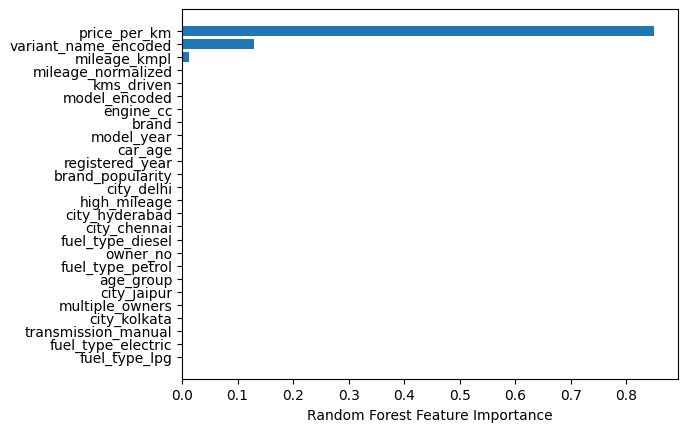

In [17]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# For tree-based models like Random Forest or Gradient Boosting
feature_importance = models['Random Forest'].feature_importances_
sorted_idx = feature_importance.argsort()
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()


In [20]:
# from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(models['Random Forest'], X, y, cv=5, scoring='r2')
print(f"Cross-Validation R-squared: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")


Cross-Validation R-squared: 0.99 ± 0.01


Save the Best Model for Deployment

In [21]:
joblib.dump(models['Random Forest'], 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']